### **SETUP:**

**Add pre-installed package path & load packages:**

In [1]:
.libPaths(c(.libPaths(), "/exports/eddie3_apps_local/apps/SL7/R/4.3.0/lib64/R/library"))

In [2]:
#remotes::install_github('MRCIEU/TwoSampleMR')

In [2]:
library("dplyr", warn.conflicts = F)
library("stringr", warn.conflicts = F)
library("data.table", warn.conflicts = F) 
library("vroom", warn.conflicts = F)
library("ggplot2", warn.conflicts = F)
library("TwoSampleMR")
library("readxl")

TwoSampleMR version 0.5.11 
[>] New: Option to use non-European LD reference panels for clumping etc
[>] Some studies temporarily quarantined to verify effect allele
[>] See news(package = 'TwoSampleMR') and https://gwas.mrcieu.ac.uk for further details



You are running an old version of the TwoSampleMR package.
This version:   0.5.11
Latest version: 0.6.15
Please consider updating using remotes::install_github('MRCIEU/TwoSampleMR')



**Change working directory:**

In [4]:
wd = "/exports/cmvm/eddie/smgphs/groups/Quantgen/Users/vasilis/PHD/"
setwd(wd)
getwd()

[1] "/exports/cmvm/eddie/smgphs/groups/Quantgen/Users/vasilis/PHD"

### **Extract instruments (non-clumped):**

In [4]:
## column names to extract
default_2smr_cols    <- c("Phenotype", "SNP", "chr", "position", "effect_allele", "other_allele", "beta", "se", "pval", "eaf", "samplesize")
## all protein exposure names
protein_list <- list.files("SBpQTL_project/SBMR/data/1.GWAS_on_protein/")

# progress bar
pb = txtProgressBar(min = 0, max = length(protein_list), initial = 0) 

## protein loop  
for (i in 1:length(protein_list)){
#for (i in c(1,1172:1175)){
     ## protein name 
    exp_i_name = protein_list[i]
    #cat(paste(exp_i_name, "...\t"))
    ## load protein sumstats
    exp_i_file <- paste0("SBpQTL_project/SBMR/data/1.GWAS_on_protein/", exp_i_name, "/2.Step_2/Step2_", exp_i_name, "_NPX.regenie")
    ## skip proteins with no sumstats
    if (file.exists(exp_i_file)==FALSE) next
    ## filter & reformat
    exp_i <- 
        fread(exp_i_file) %>%
        # make phenotype (protein name) & pvalue column
        mutate(Phenotype = exp_i_name,
               pval = 10^(-LOG10P)) %>%
        # filter pQTL ~ protein associations with pval < 5e-8
        filter(pval <= 5e-8) %>% 
        # rename columns to match 2smr defaults
        rename(Phenotype = Phenotype,
               SNP = ID,
               beta = BETA,
               se = SE,
               effect_allele = ALLELE1,
               other_allele = ALLELE0,
               pval = pval,
               chr = CHROM,
               position = GENPOS,
               eaf = A1FREQ,
               samplesize = N
               ) %>%
        select(all_of(default_2smr_cols)) %>%
        as.data.frame
    #cat(paste(nrow(exp_i), "non-clumped pQTLs\n"))
    # append all sumstats in one df
    if(exp_i_name == protein_list[1]) {
        #cat("... Starting binding all pQTLs ...\n")
        exp_all = exp_i
    }
    else {
        exp_all <- bind_rows(exp_all, exp_i)
        #cat(paste("... ", nrow(exp_all), "pQTLs in total ...\n"))
    }
    # print progress 
    setTxtProgressBar(pb,i)   
    cat(paste0("\rExtracted ", i, " out of ",  length(protein_list), " proteins (", round((i / length(protein_list)*100),2), "%) ..."))
}


In [12]:
dim(exp_all)
unique(exp_all$Phenotype) %>% length

[1] 339899     11

[1] 2464

In [13]:
## save non-clumped pqtls
# system("mkdir -p pQTL_MR_analysis/data", intern=T)
# write.table(exp_all, "pQTL_MR_analysis/data/pQTLs_non_clumped.txt", sep = " ", quote=F, row.names = F)

character(0)

### **Liftover pQTLs to hg38 & extract cis-pQTLs:**

In [5]:
exp_all <- fread("pQTL_MR_analysis/data/pQTLs_non_clumped.txt")

In [6]:
LIFTOVER  = "/exports/cmvm/eddie/smgphs/groups/Quantgen/Users/vasilis/PHD/software/liftOver"
CHAINFILE = "/exports/cmvm/eddie/smgphs/groups/Quantgen/Users/vasilis/PHD/resources/liftOver_files/hg19ToHg38.over.chain.gz"
OUTDIR    = "/exports/cmvm/eddie/smgphs/groups/Quantgen/Users/vasilis/PHD/pQTL_MR_analysis/data/"
temp_in_file = "/exports/cmvm/eddie/smgphs/groups/Quantgen/Users/vasilis/PHD/pQTL_MR_analysis/data/temp_liftover_in.BED"

#exp_clumped <- fread("pQTL_MR_analysis/data/per_protein/pQTLs_clumped_thres0.2.txt") %>% as.data.frame

# make BED input
temp_in <- exp_all %>% 
#temp_in <- exp_pruned %>% 
#temp_in <- exp_clumped %>%     
    mutate(CHR = paste0("chr", chr), POS0 = position-1) %>% 
    select(CHR, POS0, position, SNP) %>% 
    arrange(SNP) %>% filter(!duplicated(SNP)) # select only unique SNPs
write.table(temp_in, temp_in_file, quote=F, row.names = F, col.names = F)
# run liftOver
system(paste0(
    LIFTOVER,
    " -bedPlus=3 ", 
    temp_in_file, " ",
    CHAINFILE, " ",
    OUTDIR, "temp_liftover_out.BED ",
    OUTDIR, "temp_liftover_unmapped.BED "),
       intern = T
      )
# load hg38 positions (excludes unmapped)
temp_hg38 <- fread("pQTL_MR_analysis/data/temp_liftover_out.BED")

exp_all_hg38 <-
    left_join(x=exp_all, y=temp_hg38[,c("V1","V3","V4")], by=c("SNP"="V4")) %>% 
# exp_pruned_hg38 <-
#     left_join(x=exp_pruned, y=temp_hg38[,c("V1","V3","V4")], by=c("SNP"="V4")) %>% 
# exp_clumped_hg38 <-
#    left_join(x=exp_clumped, y=temp_hg38[,c("V1","V3","V4")], by=c("SNP"="V4")) %>% 
    rename(position_hg38 = V3) %>%
    mutate(chr38 = gsub("chr", "", V1)) %>%
    filter(chr==chr38) %>%
    select(-c(V1, chr38))
# remove temp data
system("rm pQTL_MR_analysis/data/temp_*", intern=T)

character(0)

character(0)

*Load metadata:*

In [7]:
# assay table 
file <- "/exports/cmvm/eddie/smgphs/groups/Quantgen/Users/ukb_data/ukb44986/proteomics/olink_assay.dat"
assay <- fread(file)
# replace "-" with "_" in assay (protein) names
assay <- assay %>% mutate(Assay = gsub("-", "_", Assay))

In [8]:
# genomic positions table
file <- "/exports/cmvm/eddie/smgphs/groups/Quantgen/Users/vasilis/PHD/proteomics/Resource/Proteome/Sun_etal_sup/proteins_positions.txt"
pos  <- fread(file)

In [9]:
pos <-
pos %>% 
    mutate(UniProt = gsub(";.*","",UniProt)) %>%
    mutate(Gene_CHROM = gsub(";.*","",Gene_CHROM)) %>%
    mutate(Gene_start = gsub(";.*","",Gene_start))%>% 
    mutate(Gene_end = gsub(";.*","",Gene_end)) %>%
    filter(!duplicated(UniProt))


In [10]:
# merge protein (gene) info with exposure table & define cis pQTLs : within 1 Mb from the gene encoding the protein
exp_all_annot <- 
inner_join(x=exp_all_hg38, y=assay, by=c("Phenotype"="Assay")) %>% 
#exp_pruned_annot <- 
#inner_join(x=exp_pruned_hg38, y=assay, by=c("Phenotype"="Assay")) %>% 
#exp_clumped_annot <- 
#inner_join(x=exp_clumped_hg38, y=assay, by=c("Phenotype"="Assay")) %>% 
    mutate(UniProt2 = gsub("-.*","", UniProt)) %>% 
    mutate(UniProt2 = gsub("_.*","", UniProt2)) %>%
    left_join(x=., y=pos[,-c("Assay_Target","Gene_symbol")], by=c("UniProt2"="UniProt")) %>% 
    mutate(Gene_CHROM = gsub("X","23",Gene_CHROM),
           Gene_CHROM = as.numeric(Gene_CHROM),
           Gene_start = as.numeric(Gene_start),
           Gene_end = as.numeric(Gene_end)
          ) %>%
    # define cis (<= 1Mb of the gene); otherwise trans
    mutate(IsCis = case_when( chr == Gene_CHROM & (position_hg38 >= Gene_start-1e6) &  (position_hg38 <= Gene_end+1e6) ~ 1,
                              TRUE ~ 0
                            )
          ) 

In [11]:
## extract cis-pQTLs
exp_all_annot_cis <- exp_all_annot[exp_all_annot$IsCis==1,]
nrow(exp_all_annot_cis)
#write.table(exp_all_annot_cis, "pQTL_MR_analysis/data/pQTLs_non_clumped_cis.txt", sep = " ", quote=T, row.names = F)

[1] 87331

### **LD pruning:**

In [7]:
exp_all <- fread("pQTL_MR_analysis/data/pQTLs_non_clumped.txt")

In [8]:
# extract unique SNP ids for pruning
system("cat pQTL_MR_analysis/data/pQTLs_non_clumped.txt | awk 'NR > 1 {print $2}' | sort | uniq > pQTL_MR_analysis/data/pQTLs_non_clumped_uniq.txt", intern=T) 

character(0)

In [6]:
# load plink 
system("module load igmm/apps/plink/1.90b7.2", intern = T)
system("/gpfs/igmmfs01/software-rl9/apps/plink/1.90b7.2/plink --indep-pairwise --help | head", intern = T)

character(0)

[1] "PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/" "(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3"
 [3] "--help present, ignoring other flags."                                          ""                                                                              
 [5] "--indep <window size>['kb'] <step size (variant ct)> <VIF threshold>"           "--indep-pairwise <window size>['kb'] <step size (variant ct)> <r^2 threshold>" 
 [7] "--indep-pairphase <window size>['kb'] <step size (variant ct)> <r^2 thresh>"    "  Generate a list of markers in approximate linkage equilibrium.  With the"    
 [9] "  'kb' modifier, the window size is in kilobase instead of variant count"       "  units.  (Pre-'kb' space is optional, i.e. \"--indep-pairwise 500 kb 5 0.5\""

In [7]:
## run pruning
plink    = "/gpfs/igmmfs01/software-rl9/apps/plink/1.90b7.2/plink"
bedfile  = "/exports/cmvm/eddie/smgphs/groups/Quantgen/Users/ybhak/Projects/AIM-CISC/Analysis/Second_Mockup/Result/0.Genotype/unrelated_qc_array_genotypes_XY"
pQTLs_in = "pQTL_MR_analysis/data/pQTLs_non_clumped_uniq.txt"
pQTLs_out= "pQTL_MR_analysis/data/pQTLs"
r2 = 0.1
system(paste0(
    plink,
    " --bfile ", bedfile,
    " --extract ", pQTLs_in,
    " --indep-pairwise 500kb 1 ", r2, # r2=0.05 maybe too low 
    " --out ", paste0(pQTLs_out,r2),
    " --threads $(nproc)"),
    intern = F
      )

In [8]:
## load pruned SNPs
file   <- paste0(pQTLs_out, r2, ".prune.in")
pruned <- fread(file, header=F)$V1
pruned %>% length

[1] 19419

In [9]:
## extract pruned SNPs 
exp_pruned <- exp_all %>% filter(SNP %in% pruned) %>% as.data.frame
## check proteins that lose all pQTLs after pruning 
prots.rm <- setdiff(exp_all$Phenotype ,exp_pruned$Phenotype)
cat(paste0(length(prots.rm), " proteins with no pruned pQTLs:\n\n"), prots.rm)

223 proteins with no pruned pQTLs:

 ACOX1 ACSL1 AHSA1 AIF1 AIFM1 AK2 ALDH2 ANXA10 AP2B1 AP3B1 AP3S2 ARF6 ARL13B ARNT ATP6V1D ATP6V1F AZI2 BAG4 BAMBI BAP18 BCL2 BCL2L1 BIRC2 BLOC1S3 BNIP2 CALB2 CAMSAP1 CAPN3 CASP2 CCT5 CD2 CDC37 CDC42BPB CEBPA CEP170 CEP290 CERT CHM CLPP CLSTN1 CMIP COMMD9 COX6B1 CRKL CSRP3 CTF1 DARS1 DCN DCTN2 DCTN6 DDX25 DECR1 DEFB116 DENR DFFA DHPS DLG4 DNAJA2 DNAJB14 DNAJC9 DOK1 DTX2 EDNRB EIF4E EIF5 ENOX2 ESR1 EVI5 FEN1 FKBP7 FKBPL FNTA FOSB FOXJ3 FOXO3 FUS GABARAPL1 GAPDH GATD3 GCC1 GFER GH2 GIT1 GOPC GPI GRAP2 GRSF1 GUCY2C HARS1 HDAC8 HIP1 HNRNPK HTRA2 IGFBP1 IL11 IL1A IL36A ILKAP IMPACT IMPG1 ING1 INPPL1 IRAG2 IRAK1 KCTD5 KIF1C KLHL41 KRT8 LARP1 LAT2 LATS1 LETM1 M6PR MAP1LC3B2 MARS1 MITD1 MMUT MYCBP2 MYLPF MZT1 NAA10 NACC1 NAMPT NARS1 NBN NDUFB7 NEO1 NFX1 NOS3 NRGN OTUD6B OTUD7B P4HB PAIP2B PAK4 PARD3 PBXIP1 PCBP2 PDP1 PEBP1 PGA4 PITHD1 PLCB1 PLIN1 PPIF PPM1B PPM1F PPP1CC PPP1R14D PRDX3 PRKD2 PSMD1 PTK7 PTPN1 PTPRR RAB39B RAD23B RALY RCC1 RCOR1 RGS10 RNF4 RNF41

### **LD clumping:**

Steps:
1. **UPDATE (14.03.25):** Start with cis-pQTLs
2. make per protein non-clumped sumstats files
3. thin down reference plink files; use proteomics ids and pQTLs_non_clumped_uniq.txt
4. run clumping with plink -> per protein files prot.clumped
5. combine all prot.clumped snplists (some will overlap - its fine i guess)
  

In [13]:
# non-pruned cis pQTLs
exp_all_annot_cis <- fread("pQTL_MR_analysis/data/pQTLs_non_clumped_cis.txt")
# list of exposures
exp_prots <- unique(exp_all_annot_cis$Phenotype)
length(exp_prots)
# make output dir
out_dir = "pQTL_MR_analysis/data/per_protein/non_clumped/cis"
cmd = paste0("mkdir -p ", out_dir)
system(cmd)

[1] 1860

In [44]:
## make per-protein non-clumped files (for plink --clump)

# progress bar
pb = txtProgressBar(min = 0, max = length(exp_prots), initial = 0) 

# loop each protein
for (i in 1:length(exp_prots)){
    exp_i_name = exp_prots[i]
    # extract & write per-protein non-pruned pQTLs table
    exp_i <- exp_all_annot_cis[exp_all_annot_cis$Phenotype==exp_i_name,]
    out_i = paste0(out_dir,"/", exp_i_name, "_CIS_nonclumped_for_plink.txt")
    write.table(exp_i, file = out_i, row.names=F, quote=F, sep=" ")
    # print progress 
    setTxtProgressBar(pb,i)   
}


In [14]:
# load plink 
system("module load igmm/apps/plink/1.90b7.2", intern = T)
system("/gpfs/igmmfs01/software-rl9/apps/plink/1.90b7.2/plink --clump --help | head", intern = T)

character(0)

[1] "PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/" "(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3"
 [3] "--help present, ignoring other flags."                                          ""                                                                              
 [5] "--clump <PLINK report filename(s)...>"                                          "  Process association analysis report(s) with 'SNP' and p-value columns,"      
 [7] "  organizing results by LD-based clumps.  Multiple filenames can be separated"  "  by spaces or commas."                                                        
 [9] ""                                                                               "--clump-p1 <pval> : Set --clump index var. p-value ceiling (default 1e-4)."

In [46]:
# ids to keep for reference plink files 
keepfile = "pQTL_MR_analysis/data/ids.to.keep"
keep <- fread("/exports/cmvm/eddie/smgphs/groups/Quantgen/Users/vasilis/PHD/proteomics/delirium/data/data_int_clean.csv", select = "IID") %>% mutate(FID=IID)
write.table(keep, file=keepfile, row.names=F, quote=F, col.names=F, sep=" ")

In [37]:
## thin down reference plink files
plink    = "/gpfs/igmmfs01/software-rl9/apps/plink/1.90b7.2/plink"
bedfile  = "/exports/cmvm/eddie/smgphs/groups/Quantgen/Users/ybhak/Projects/AIM-CISC/Analysis/Second_Mockup/Result/0.Genotype/unrelated_qc_array_genotypes_XY"
keepfile = "pQTL_MR_analysis/data/ids.to.keep"
extract  = "pQTL_MR_analysis/data/pQTLs_non_clumped_uniq.txt"
outdir   = "pQTL_MR_analysis/data/plink"

cmd = paste0("mkdir -p ", outdir)
system(cmd)

system(paste0(
    plink,
    " --bfile ", bedfile,
    " --extract ", extract,
    " --keep ", keepfile,
    " --out ", paste0(outdir, "/ref"),
    " --make-bed ",
    " --threads $(nproc)"),
    intern = F
      )

In [ ]:
## run clumping 
r2 = 0.2
plink    = "/gpfs/igmmfs01/software-rl9/apps/plink/1.90b7.2/plink"
bedfile  = "pQTL_MR_analysis/data/plink/ref" # use thinned down from above
pQTLs_in = "pQTL_MR_analysis/data/per_protein/non_clumped/cis/" # dir
pQTLs_out= paste0("pQTL_MR_analysis/data/per_protein/clumped/cis/", r2, "/") # dir
p1 = 5e-8 # clump-p1
pname = "pval" 

# make output dir
system(paste0("mkdir -p ", pQTLs_out, "logs/"))

# locate each protein input
for (i in 1:length(exp_prots)){
    prot = exp_prots[i]
    clumpfile = paste0(pQTLs_in, prot, "_CIS_nonclumped_for_plink.txt")
    # run plink clumping
    system(paste0(
        plink,
        " --bfile ", bedfile,
        " --clump ", clumpfile,
        " --clump-p1 ", p1,
        " --clump-r2 ", r2,
        " --clump-snp-field SNP ",
        " --clump-field ", pname,
        " --out ", paste0(pQTLs_out, prot),
        " --threads $(nproc)"),
        intern = F
          )
}
cmd = paste0('mv ', pQTLs_out, '*log ', pQTLs_out, 'logs')
system(cmd)


In [26]:
## make table with all clumped pQTLs
r2 = 0.2
plink    = "/gpfs/igmmfs01/software-rl9/apps/plink/1.90b7.2/plink"
bedfile  = "pQTL_MR_analysis/data/plink/ref" # use thinned down from above
pQTLs_in = "pQTL_MR_analysis/data/per_protein/non_clumped/cis/" # dir
pQTLs_out= paste0("pQTL_MR_analysis/data/per_protein/clumped/cis/", r2, "/") # dir

# progress bar
pb = txtProgressBar(min = 0, max = length(exp_prots), initial = 0) 

for (i in 1:length(exp_prots)){
    prot = exp_prots[i]
    # extract the index clumped SNPs for protein i
    clumped_file = paste0(pQTLs_out, prot, ".clumped")
    clumped_snplist <- fread(clumped_file) %>% pull(SNP)
    # extract from non-clumped table
    exp_i = exp_all_annot_cis %>% filter(Phenotype == prot & SNP %in% clumped_snplist)
    # append all sumstats in one df
    if(prot == exp_prots[1]) {
        exp_clumped_cis = exp_i
    }
    else {
        exp_clumped_cis <- bind_rows(exp_clumped_cis, exp_i)
    }
    # print progress 
    setTxtProgressBar(pb,i)   
}


In [27]:
exp_clumped_cis %>% nrow
exp_all_annot_cis %>%  nrow

[1] 33747

[1] 87331

In [29]:
# save clumped pQTLs table
cfile = paste0("pQTL_MR_analysis/data/per_protein/pQTLs_clumped_cis_thres", r2, '.csv')
fwrite(exp_clumped_cis, file=cfile)

### **Stricter MR for APOE & PVR (r2 = 0.001):**

#### ld-clumping

In [4]:
# load plink 
system("module load igmm/apps/plink/1.90b7.2", intern = T)
system("/gpfs/igmmfs01/software-rl9/apps/plink/1.90b7.2/plink --clump --help | head", intern = T)

character(0)

[1] "PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/" "(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3"
 [3] "--help present, ignoring other flags."                                          ""                                                                              
 [5] "--clump <PLINK report filename(s)...>"                                          "  Process association analysis report(s) with 'SNP' and p-value columns,"      
 [7] "  organizing results by LD-based clumps.  Multiple filenames can be separated"  "  by spaces or commas."                                                        
 [9] ""                                                                               "--clump-p1 <pval> : Set --clump index var. p-value ceiling (default 1e-4)."

In [38]:
## set protein names 
exp_prots = c('APOE', 'PVR')
## run clumping 
r2 = 0.0001
plink    = "/gpfs/igmmfs01/software-rl9/apps/plink/1.90b7.2/plink"
bedfile  = "pQTL_MR_analysis/data/plink/ref" # use thinned down from above
pQTLs_in = "pQTL_MR_analysis/data/per_protein/non_clumped/cis/" # dir
pQTLs_out= paste0("pQTL_MR_analysis/data/per_protein/clumped/cis/", r2, "/") # dir
p1 = 5e-8 # clump-p1
pname = "pval" 

# make output dir
system(paste0("mkdir -p ", pQTLs_out, "logs/"))

# locate each protein input
for (i in 1:length(exp_prots)){
    prot = exp_prots[i]
    clumpfile = paste0(pQTLs_in, prot, "_CIS_nonclumped_for_plink.txt")
    # run plink clumping
    system(paste0(
        plink,
        " --bfile ", bedfile,
        " --clump ", clumpfile,
        " --clump-p1 ", p1,
        " --clump-r2 ", r2,
        " --clump-snp-field SNP ",
        " --clump-field ", pname,
        " --out ", paste0(pQTLs_out, prot),
        " --threads $(nproc)"),
        intern = F
          )
}
cmd = paste0('mv ', pQTLs_out, '*log ', pQTLs_out, 'logs')
system(cmd)


In [40]:
# non-pruned cis pQTLs
exp_all_annot_cis <- fread("pQTL_MR_analysis/data/pQTLs_non_clumped_cis.txt")

In [41]:
## make table with all clumped pQTLs
r2 = 0.0001
plink    = "/gpfs/igmmfs01/software-rl9/apps/plink/1.90b7.2/plink"
bedfile  = "pQTL_MR_analysis/data/plink/ref" # use thinned down from above
pQTLs_in = "pQTL_MR_analysis/data/per_protein/non_clumped/cis/" # dir
pQTLs_out= paste0("pQTL_MR_analysis/data/per_protein/clumped/cis/", r2, "/") # dir

# progress bar
pb = txtProgressBar(min = 0, max = length(exp_prots), initial = 0) 

for (i in 1:length(exp_prots)){
    prot = exp_prots[i]
    # extract the index clumped SNPs for protein i
    clumped_file = paste0(pQTLs_out, prot, ".clumped")
    clumped_snplist <- fread(clumped_file) %>% pull(SNP)
    # extract from non-clumped table
    exp_i = exp_all_annot_cis %>% filter(Phenotype == prot & SNP %in% clumped_snplist)
    # append all sumstats in one df
    if(prot == exp_prots[1]) {
        exp_clumped_cis = exp_i
    }
    else {
        exp_clumped_cis <- bind_rows(exp_clumped_cis, exp_i)
    }
    # print progress 
    setTxtProgressBar(pb,i)   
}


In [44]:
exp_clumped_cis %>% nrow

[1] 11

In [45]:
# save clumped pQTLs table
 cfile = paste0("pQTL_MR_analysis/data/per_protein/pQTLs_clumped_cis_thres", r2, '.csv')
 fwrite(exp_clumped_cis, file=cfile)

#### outcome

In [46]:
### clumped cis instruments
r2=0.0001
cfile = paste0("pQTL_MR_analysis/data/per_protein/pQTLs_clumped_cis_thres", r2, '.csv')
exp_clumped_cis <- fread(cfile) %>% as.data.frame
cat(paste0('# of cis instruments: ', length(unique(exp_clumped_cis$SNP))))

# of cis instruments: 11

In [47]:
### extract pQTLs associated with >= 5 proteins
pleio_snps <- exp_clumped_cis %>% group_by(SNP) %>% summarise(n=n()) %>% filter(n >=5) %>% pull(SNP)
cat(paste0('# of instruments with >=5 protein associations: ', length(unique(pleio_snps))))

# of instruments with >=5 protein associations: 0

In [22]:
## columns to extract
default_2smr_cols    <- c("Phenotype", "SNP", "chr", "position", "effect_allele", "other_allele", "beta", "se", "pval", "eaf", "samplesize")
## load outcome
delirium_ukb <- 
    # read delirium sumstats (UKB EXCL. PROTEOMICS SET)
    fread('meta_analysis/ukb_nonprot_eur_fgQC_all_hg38_final.txt') %>% 
            filter(ID %in% exp_clumped_cis$SNP) %>% # extract only snps in exposure df
            ### IMPORTANT UPDATE: FILTER sbpqtl ~ disorder associations with pval > 5e-8
            # filter(pval > 5e-8) %>%
            mutate(Phenotype = "delirium_ukb", # name of outcome phenotype
                   N= '360901') %>% # sample size (from .log files)
            rename("SNP" = "ID",
                   "beta" = "BETA",
                   "se" = "SE",
                   "effect_allele" = "ALLELE1",
                   "other_allele" = "ALLELE0",
                   "chr" = "CHROM",
                   "position" = "GENPOS",
                   "pval" = "P",
                   "eaf" = "A1FREQ", 
                   "samplesize" = "N") %>%
            select(all_of(default_2smr_cols)) %>% 
            ## duplicated SNPs: keep the highest EAF
            arrange(SNP,desc(eaf)) %>% filter(!duplicated(SNP)) %>%
            as.data.frame
dim(delirium_ukb)
head(delirium_ukb,3)

[1] 14 11

,Phenotype,SNP,chr,position,effect_allele,other_allele,beta,se,pval,eaf,samplesize
,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,delirium_ukb,rs10417602,19,45157381,T,C,0.11981800,0.0322432,0.0002023392,0.0759807,360901
2,delirium_ukb,rs1594895,19,44376201,C,T,-0.01708520,0.0220435,0.4382995250,0.2004730,360901
3,delirium_ukb,rs1625502,19,44540845,C,G,0.00893038,0.0289286,0.7575459837,0.1048600,360901


In [23]:
## make outcome df in TwoSampleMR format
delirium_ukb$samplesize <- as.numeric(delirium_ukb$samplesize)
out_2smr <- format_data(delirium_ukb, type = "outcome")
dim(out_2smr)
head(out_2smr, 3)

[1] 14 13

,SNP,chr.outcome,effect_allele.outcome,other_allele.outcome,beta.outcome,se.outcome,pval.outcome,eaf.outcome,samplesize.outcome,outcome,mr_keep.outcome,pval_origin.outcome,id.outcome
,<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<lgl>,<chr>,<chr>
1,rs10417602,19,T,C,0.11981800,0.0322432,0.0002023392,0.0759807,360901,delirium_ukb,TRUE,reported,nMDNFM
2,rs1594895,19,C,T,-0.01708520,0.0220435,0.4382995250,0.2004730,360901,delirium_ukb,TRUE,reported,nMDNFM
3,rs1625502,19,C,G,0.00893038,0.0289286,0.7575459837,0.1048600,360901,delirium_ukb,TRUE,reported,nMDNFM


#### MR

In [24]:
## make exposure df in TwoSampleMR format
exp_2smr <- format_data(exp_clumped_cis, type = "exposure")
## harmonise exposure i and outcome j data
harmon <-
harmonise_data(
    exposure_dat = exp_2smr,
    outcome_dat = out_2smr)

Harmonising APOE (vM1cSX) and delirium_ukb (nMDNFM)

Harmonising PVR (KCkbHE) and delirium_ukb (nMDNFM)



In [48]:
harmon_cis_nopleio <-
harmon %>% 
    filter(!(SNP %in% pleio_snps) & SNP %in% exp_clumped_cis$SNP)
harmon_nopleio <- 
harmon %>% 
    filter(!(SNP %in% pleio_snps))

length(unique(harmon$SNP))
length(unique(harmon_nopleio$SNP))
length(unique(harmon_cis_nopleio$SNP))

[1] 14

[1] 14

[1] 9

In [49]:
## perform 2sampleMR:
mr_all_cis <- mr(harmon_cis_nopleio, method_list = c("mr_ivw", "mr_weighted_median", "mr_egger_regression", "mr_two_sample_ml"))

Analysing 'KCkbHE' on 'nMDNFM'

Analysing 'vM1cSX' on 'nMDNFM'



In [50]:
## pleiotropy test
mr_all_cis_pleio <- mr_pleiotropy_test(harmon_cis_nopleio)
# heterogeneity test
mr_all_cis_het <- mr_heterogeneity(harmon_cis_nopleio, method_list = c("mr_ivw"))

In [51]:
## make pretty
mr_all_cis2     <- 
    mr_all_cis %>% 
    mutate(method = case_when(method == "Inverse variance weighted" ~ "IVW",
                              method == "Maximum likelihood" ~ "ML",
                              method == "Weighted median" ~ "WM",
                              method == "MR Egger" ~ "MR_Egger",
                              TRUE ~ method)
          ) %>%
    select(-c('id.exposure','id.outcome'))
mr_all_cis_het2 <-
    mr_all_cis_het %>% 
    mutate(method = ifelse(method=="Inverse variance weighted", "IVW", method)) %>%
    select(-c('id.exposure','id.outcome'))

mr_all_cis_pleio2 <-
    mr_all_cis_pleio %>%
    select(-c('id.exposure','id.outcome'))

In [52]:
mr_all_cis2
mr_all_cis_het2
mr_all_cis_pleio2

outcome,exposure,method,nsnp,b,se,pval
<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>
delirium_ukb,PVR,IVW,5,0.05718643,0.06009085,3.412663e-01
delirium_ukb,PVR,WM,5,0.01901123,0.04195805,6.504761e-01
delirium_ukb,PVR,MR_Egger,5,-0.12391348,0.14462984,4.545612e-01
delirium_ukb,PVR,ML,5,0.05734284,0.03773139,1.285702e-01
delirium_ukb,APOE,IVW,4,-0.57498307,0.03061874,1.126069e-78
delirium_ukb,APOE,WM,4,-0.57608070,0.03178312,2.009940e-73
delirium_ukb,APOE,MR_Egger,4,-0.56522157,0.05184114,8.307558e-03
delirium_ukb,APOE,ML,4,-0.57536740,0.03123808,9.286909e-76


outcome,exposure,method,Q,Q_df,Q_pval
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
delirium_ukb,PVR,IVW,10.182867,4,0.03745744
delirium_ukb,APOE,IVW,3.119473,3,0.37356909


outcome,exposure,egger_intercept,se,pval
<chr>,<chr>,<dbl>,<dbl>,<dbl>
delirium_ukb,PVR,0.070968769,0.05246911,0.2691058
delirium_ukb,APOE,-0.005370591,0.02006374,0.8140261


Warning message:
“Removed 1 row containing missing values or values outside the scale range (`geom_errorbarh()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range (`geom_point()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range (`geom_errorbarh()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range (`geom_point()`).”


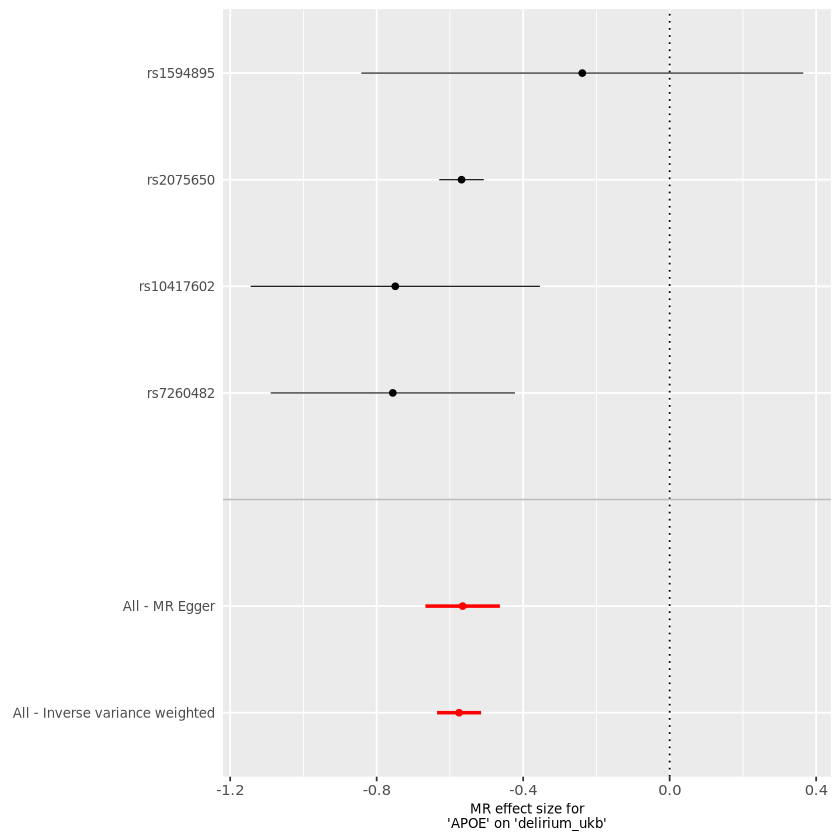

$vM1cSX.nMDNFM

attr(,"split_type")
[1] "data.frame"
attr(,"split_labels")
  id.exposure id.outcome
1      vM1cSX     nMDNFM

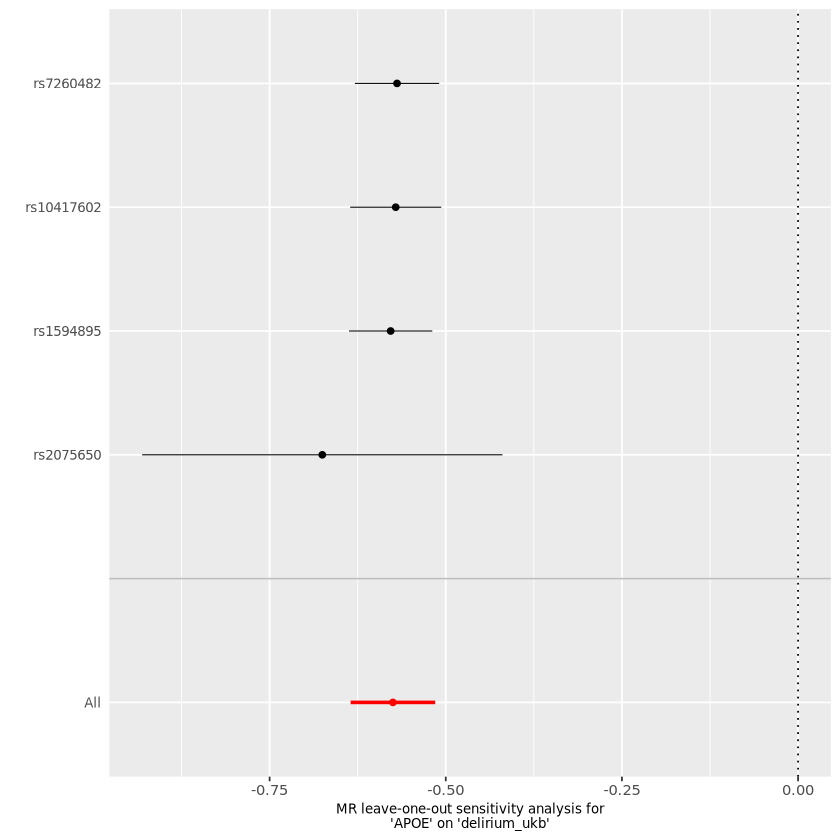

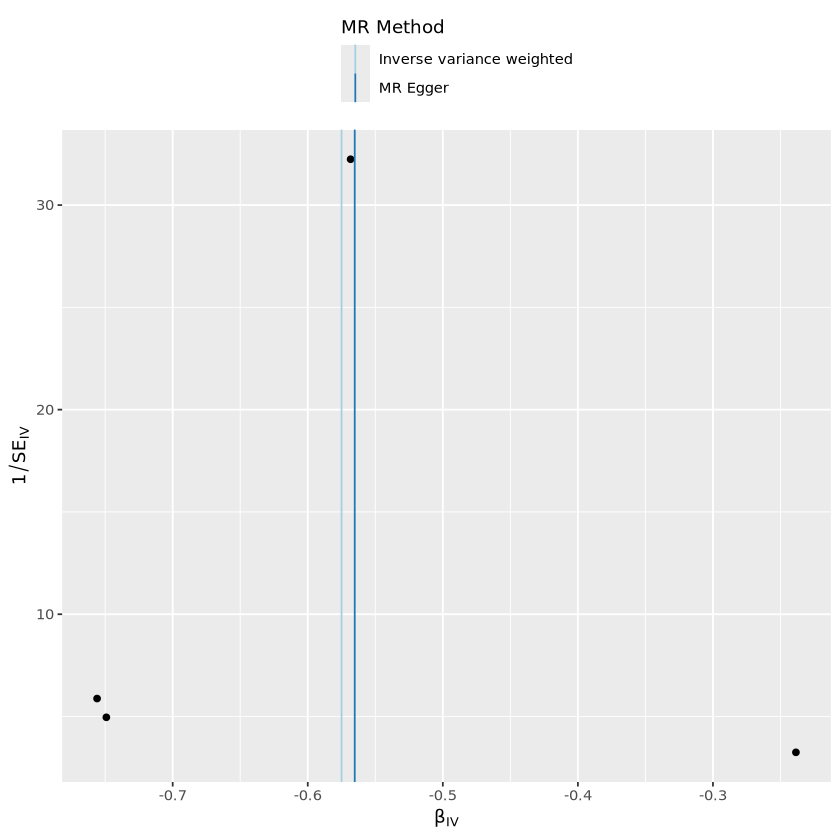

In [53]:
# forrest plot
library(patchwork)
mr_apoe <- mr_singlesnp(harmon_cis_nopleio[harmon_cis_nopleio$exposure=="APOE",])
p1 <- mr_forest_plot(mr_apoe)[[1]]
# leave one out (MR excluding each pQLT one by one)
mr_loo_apoe <- mr_leaveoneout(harmon_cis_nopleio[harmon_cis_nopleio$exposure=="APOE",])
p2 <- mr_leaveoneout_plot(mr_loo_apoe)[[1]]
# funnel plot
p3 <- mr_funnel_plot(mr_apoe)
p1
p2
p3

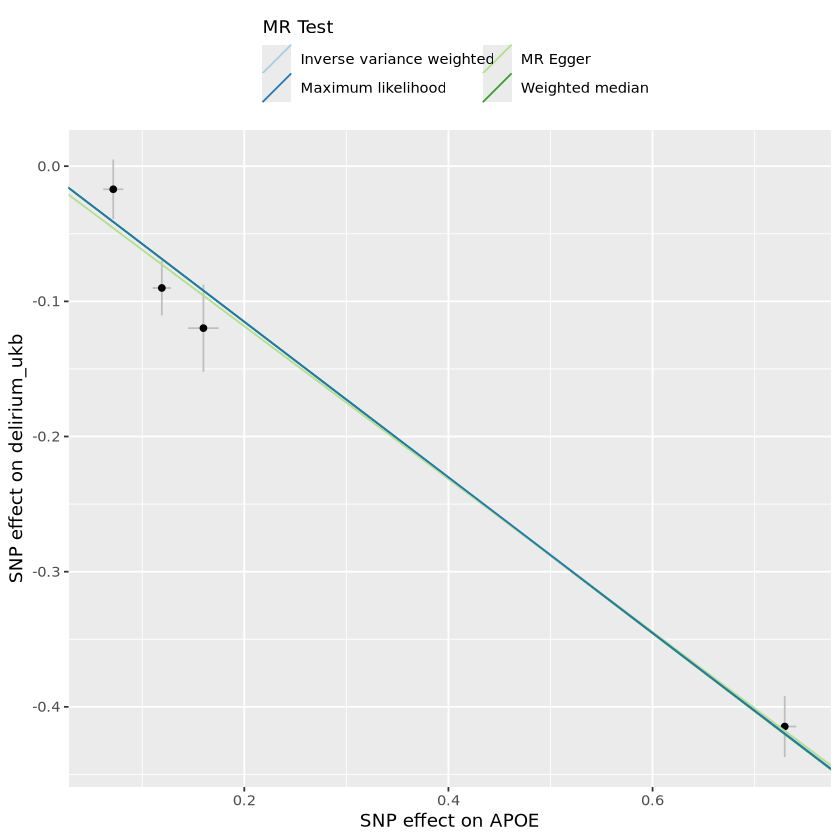

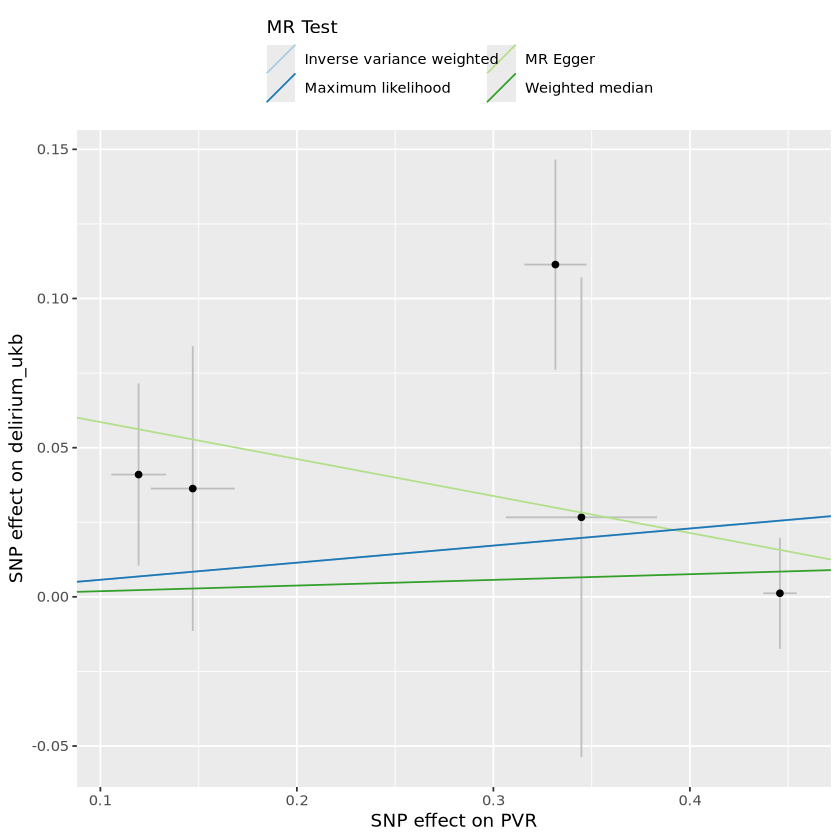

In [54]:
mr_scatter_plot(mr_all_cis[mr_all_cis$exposure=="APOE",], harmon_cis_nopleio[harmon_cis_nopleio$exposure=="APOE",])[[1]]
mr_scatter_plot(mr_all_cis[mr_all_cis$exposure=="PVR",], harmon_cis_nopleio[harmon_cis_nopleio$exposure=="PVR",])[[1]] 

### **START HERE: Outcome:**

For discovery   -> UKB <br>
For replication -> 1. in AoU EUR delirium GWAS 2. in FG-r10

In [5]:
nc <- fread('pQTL_MR_analysis/data/pQTLs_non_clumped.txt')
nc$Phenotype %>% unique %>% length

[1] 2464

In [6]:
### clumped cis+trans instruments

r2=0.2
cfile = paste0("pQTL_MR_analysis/data/per_protein/pQTLs_clumped_thres", r2, '.txt')
exp_clumped <- fread(cfile) %>% as.data.frame
cat(paste0('# of cis+trans instruments: ', length(unique(exp_clumped$SNP))))

# of cis+trans instruments: 41446

In [7]:
### clumped cis instruments

r2=0.2
cfile = paste0("pQTL_MR_analysis/data/per_protein/pQTLs_clumped_cis_thres", r2, '.csv')
exp_clumped_cis <- fread(cfile) %>% as.data.frame
cat(paste0('# of cis instruments: ', length(unique(exp_clumped_cis$SNP))))

# of cis instruments: 29370

In [8]:
### extract pQTLs associated with >= 5 proteins
pleio_snps <- exp_clumped %>% group_by(SNP) %>% summarise(n=n()) %>% filter(n >=5) %>% pull(SNP)
cat(paste0('# of instruments with >=5 protein associations: ', length(unique(pleio_snps))))

# of instruments with >=5 protein associations: 1969

#### Discovery (UKB)

In [9]:
## columns to extract
default_2smr_cols    <- c("Phenotype", "SNP", "chr", "position", "effect_allele", "other_allele", "beta", "se", "pval", "eaf", "samplesize")
## load outcome
delirium_ukb <- 
    # read delirium sumstats (UKB EXCL. PROTEOMICS SET)
    fread('meta_analysis/ukb_nonprot_eur_fgQC_all_hg38_final.txt') %>% 
            filter(ID %in% exp_clumped$SNP) %>% # extract only snps in exposure df
            ### IMPORTANT UPDATE: FILTER sbpqtl ~ disorder associations with pval > 5e-8
            # filter(pval > 5e-8) %>%
            mutate(Phenotype = "delirium_ukb", # name of outcome phenotype
                   N= '360901') %>% # sample size (from .log files)
            rename("SNP" = "ID",
                   "beta" = "BETA",
                   "se" = "SE",
                   "effect_allele" = "ALLELE1",
                   "other_allele" = "ALLELE0",
                   "chr" = "CHROM",
                   "position" = "GENPOS",
                   "pval" = "P",
                   "eaf" = "A1FREQ", 
                   "samplesize" = "N") %>%
            select(all_of(default_2smr_cols)) %>% 
            ## duplicated SNPs: keep the highest EAF
            arrange(SNP,desc(eaf)) %>% filter(!duplicated(SNP)) %>%
            as.data.frame
dim(delirium_ukb)
head(delirium_ukb,3)

[1] 40693    11

,Phenotype,SNP,chr,position,effect_allele,other_allele,beta,se,pval,eaf,samplesize
,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,delirium_ukb,Affx-52334201,19,831815,G,GT,-0.03930490,0.0841427,0.6404128,0.011136,360901
2,delirium_ukb,Affx-52334718,20,3231072,A,AT,0.02079960,0.0177456,0.2411587,0.463883,360901
3,delirium_ukb,rs1000110,9,115146442,T,C,-0.00464618,0.0194082,0.8108009,0.294212,360901


In [13]:
## make outcome df in TwoSampleMR format
delirium_ukb$samplesize <- as.numeric(delirium_ukb$samplesize)
out_2smr <- format_data(delirium_ukb, type = "outcome")
dim(out_2smr)
head(out_2smr, 3)

[1] 40693    13

,SNP,chr.outcome,effect_allele.outcome,other_allele.outcome,beta.outcome,se.outcome,pval.outcome,eaf.outcome,samplesize.outcome,outcome,mr_keep.outcome,pval_origin.outcome,id.outcome
,<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<lgl>,<chr>,<chr>
1,affx-52334201,19,G,GT,-0.03930490,0.0841427,0.6404128,0.011136,360901,delirium_ukb,TRUE,reported,iTeu6x
2,affx-52334718,20,A,AT,0.02079960,0.0177456,0.2411587,0.463883,360901,delirium_ukb,TRUE,reported,iTeu6x
3,rs1000110,9,T,C,-0.00464618,0.0194082,0.8108009,0.294212,360901,delirium_ukb,TRUE,reported,iTeu6x


### **MR:**

*harmonise (all pQTLs):*

In [11]:
## make exposure df in TwoSampleMR format
exp_2smr <- format_data(exp_clumped, type = "exposure")
## harmonise exposure i and outcome j data
harmon <-
harmonise_data(
    exposure_dat = exp_2smr,
    outcome_dat = out_2smr)

Harmonising AZU1 (eeoZIx) and delirium_ukb (lQ5Klx)

Harmonising ATRN (VG0AzR) and delirium_ukb (lQ5Klx)

Harmonising ITPA (pugwxD) and delirium_ukb (lQ5Klx)

Harmonising MATN2 (fmabJS) and delirium_ukb (lQ5Klx)

Harmonising TNC (oIbtsh) and delirium_ukb (lQ5Klx)

Harmonising VSTM2L (wilxvr) and delirium_ukb (lQ5Klx)

Harmonising LRPAP1 (nPzFZV) and delirium_ukb (lQ5Klx)

Removing the following SNPs for being palindromic with intermediate allele frequencies:
rs2071465, rs2395004

Harmonising HGF (iEwcLJ) and delirium_ukb (lQ5Klx)

Harmonising LRP1 (4j8mCz) and delirium_ukb (lQ5Klx)

Removing the following SNPs for being palindromic with intermediate allele frequencies:
rs1632854, rs2071465, rs2395004

Harmonising BST1 (wDGi8x) and delirium_ukb (lQ5Klx)

Removing the following SNPs for being palindromic with intermediate allele frequencies:
rs4802188

Harmonising FGFBP2 (IRh7JV) and delirium_ukb (lQ5Klx)

Removing the following SNPs for being palindromic with intermediate allele frequen

*exclude pleiotropic pQTLs & extract cis-pQTLs*:

In [14]:
harmon_cis_nopleio <-
harmon %>% 
    filter(!(SNP %in% pleio_snps) & SNP %in% exp_clumped_cis$SNP)
harmon_nopleio <- 
harmon %>% 
    filter(!(SNP %in% pleio_snps))

length(unique(harmon$SNP))
length(unique(harmon_nopleio$SNP))
length(unique(harmon_cis_nopleio$SNP))

[1] 40693

[1] 38775

[1] 27948

#### **cis-pQTLs MR:**

In [146]:
## perform 2sampleMR:
mr_all_cis <- mr(harmon_cis_nopleio, method_list = c("mr_ivw", "mr_weighted_median", "mr_egger_regression", "mr_two_sample_ml"))

Analysing '01vuod' on 'PLoTSQ'

Analysing '04aDX7' on 'PLoTSQ'

Analysing '05ki0T' on 'PLoTSQ'

Analysing '07SKi0' on 'PLoTSQ'

Analysing '08jku6' on 'PLoTSQ'

Analysing '09d5Mb' on 'PLoTSQ'

Analysing '0C2yuA' on 'PLoTSQ'

Analysing '0d4VvH' on 'PLoTSQ'

Analysing '0E9FJQ' on 'PLoTSQ'

Analysing '0eZC0L' on 'PLoTSQ'

Analysing '0i3obs' on 'PLoTSQ'

Analysing '0IGBwp' on 'PLoTSQ'

Analysing '0IZDi9' on 'PLoTSQ'

Analysing '0jf5ZC' on 'PLoTSQ'

Analysing '0jY1yH' on 'PLoTSQ'

Analysing '0KVBr5' on 'PLoTSQ'

Analysing '0L041e' on 'PLoTSQ'

Analysing '0L34h1' on 'PLoTSQ'

Analysing '0LT5pW' on 'PLoTSQ'

Analysing '0MBR7O' on 'PLoTSQ'

Analysing '0Nh02f' on 'PLoTSQ'

Analysing '0OaLlq' on 'PLoTSQ'

Analysing '0RfYRo' on 'PLoTSQ'

Analysing '0s0iUd' on 'PLoTSQ'

Analysing '0Sncbb' on 'PLoTSQ'

Analysing '0trdb3' on 'PLoTSQ'

Analysing '0tuqOC' on 'PLoTSQ'

Analysing '0TXiCT' on 'PLoTSQ'

Analysing '0UNvpI' on 'PLoTSQ'

Analysing '103si1' on 'PLoTSQ'

Analysing '109XZz' on 'PLoTSQ'

Analysin

In [147]:
## pleiotropy test
mr_all_cis_pleio <- mr_pleiotropy_test(harmon_cis_nopleio)
# heterogeneity test
mr_all_cis_het <- mr_heterogeneity(harmon_cis_nopleio, method_list = c("mr_ivw"))

Not enough SNPs available for pleiotropy analysis of '08jku6' on 'PLoTSQ'

Not enough SNPs available for pleiotropy analysis of '0C2yuA' on 'PLoTSQ'

Not enough SNPs available for pleiotropy analysis of '0IGBwp' on 'PLoTSQ'

Not enough SNPs available for pleiotropy analysis of '0tuqOC' on 'PLoTSQ'

Not enough SNPs available for pleiotropy analysis of '2ajmuJ' on 'PLoTSQ'

Not enough SNPs available for pleiotropy analysis of '2vYbUG' on 'PLoTSQ'

Not enough SNPs available for pleiotropy analysis of '2XcH97' on 'PLoTSQ'

Not enough SNPs available for pleiotropy analysis of '2zwrtf' on 'PLoTSQ'

Not enough SNPs available for pleiotropy analysis of '3AYVop' on 'PLoTSQ'

Not enough SNPs available for pleiotropy analysis of '3hrREK' on 'PLoTSQ'

Not enough SNPs available for pleiotropy analysis of '3oNO0e' on 'PLoTSQ'

Not enough SNPs available for pleiotropy analysis of '3Qh5FJ' on 'PLoTSQ'

Not enough SNPs available for pleiotropy analysis of '3YHdot' on 'PLoTSQ'

Not enough SNPs available

In [148]:
## make pretty
mr_all_cis2     <- 
    mr_all_cis %>% 
    mutate(method = case_when(method == "Inverse variance weighted" ~ "IVW",
                              method == "Maximum likelihood" ~ "ML",
                              method == "Weighted median" ~ "WM",
                              method == "MR Egger" ~ "MR_Egger",
                              TRUE ~ method)
          ) %>%
    select(-c('id.exposure','id.outcome'))
mr_all_cis_het2 <-
    mr_all_cis_het %>% 
    mutate(method = ifelse(method=="Inverse variance weighted", "IVW", method)) %>%
    select(-c('id.exposure','id.outcome'))

mr_all_cis_pleio2 <-
    mr_all_cis_pleio %>%
    select(-c('id.exposure','id.outcome'))

In [149]:
ivw <-
mr_all_cis2 %>% 
    filter(method=='IVW') %>%
    mutate(fdr = p.adjust(pval, 'fdr'))
nrow(ivw)
ivw %>% filter(fdr < 0.05) %>% arrange(b)


[1] 1738

outcome,exposure,method,nsnp,b,se,pval,fdr
<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
delirium_ukb,CALB1,IVW,2,-0.77304279,0.17927089,1.616754e-05,2.554472e-03
delirium_ukb,APOE,IVW,36,-0.52557330,0.03683868,3.519371e-46,6.116667e-43
delirium_ukb,RILPL2,IVW,4,-0.50202694,0.14973587,8.001291e-04,3.311010e-02
delirium_ukb,NUDT16,IVW,3,-0.47704221,0.11161357,1.919520e-05,2.566251e-03
delirium_ukb,CEACAM19,IVW,15,-0.44630169,0.09166163,1.121568e-06,4.873212e-04
delirium_ukb,RAB44,IVW,6,-0.35639027,0.09516844,1.805113e-04,1.120459e-02
delirium_ukb,CNPY4,IVW,16,-0.35188509,0.06694478,1.469440e-07,8.512953e-05
delirium_ukb,WARS,IVW,16,-0.24582811,0.05249233,2.825348e-06,6.138069e-04
delirium_ukb,DSG2,IVW,18,-0.20358519,0.05638040,3.051114e-04,1.710592e-02


In [153]:
mr_all_cis2fdr <- left_join(mr_all_cis2, ivw[,c('exposure','method','outcome', 'fdr')], by=c('exposure', 'outcome', 'method'))

In [162]:
# save results (cis-pqtls)
resultsdir = paste0("pQTL_MR_analysis/results/with_clumped", "/thres", r2, '/ukb_nopleio')
system(paste0("mkdir -p ", resultsdir), intern=T)
fwrite(mr_all_cis2fdr, paste0(resultsdir, "/mr_pQTLs_delirium_1by1_thres", r2, "_cis_main.csv"))     # main table
fwrite(mr_all_cis_pleio2, paste0(resultsdir, "/mr_pQTLs_delirium_1by1_thres", r2, "_cis_pleio.csv")) # plei test
fwrite(mr_all_cis_het2, paste0(resultsdir, "/mr_pQTLs_delirium_1by1_thres", r2, "_cis_het.csv"))     # heterogeneity test
# save dfs (for ploting)
saveRDS(mr_all_cis, paste0(resultsdir, "/mr_all_cis.rds"))                  # original MR df
saveRDS(harmon_cis_nopleio, paste0(resultsdir, "/harmon_cis_nopleio.rds"))  # original harmon df


character(0)

#### **cis+trans pQTLs MR:**

In [167]:
## perform 2sampleMR:
mr_all <- mr(harmon_nopleio, method_list = c("mr_ivw", "mr_weighted_median", "mr_egger_regression", "mr_two_sample_ml"))

Analysing '01vuod' on 'PLoTSQ'

Analysing '04aDX7' on 'PLoTSQ'

Analysing '05ki0T' on 'PLoTSQ'

Analysing '07SKi0' on 'PLoTSQ'

Analysing '08jku6' on 'PLoTSQ'

Analysing '09d5Mb' on 'PLoTSQ'

Analysing '0C2yuA' on 'PLoTSQ'

Analysing '0d4VvH' on 'PLoTSQ'

Analysing '0E9FJQ' on 'PLoTSQ'

Analysing '0eZC0L' on 'PLoTSQ'

Analysing '0i3obs' on 'PLoTSQ'

Analysing '0IGBwp' on 'PLoTSQ'

Analysing '0IZDi9' on 'PLoTSQ'

Analysing '0jf5ZC' on 'PLoTSQ'

Analysing '0jY1yH' on 'PLoTSQ'

Analysing '0KVBr5' on 'PLoTSQ'

Analysing '0L041e' on 'PLoTSQ'

Analysing '0L34h1' on 'PLoTSQ'

Analysing '0LT5pW' on 'PLoTSQ'

Analysing '0MBR7O' on 'PLoTSQ'

Analysing '0NCbGM' on 'PLoTSQ'

Analysing '0Nh02f' on 'PLoTSQ'

Analysing '0OaLlq' on 'PLoTSQ'

Analysing '0RfYRo' on 'PLoTSQ'

Analysing '0rlQuw' on 'PLoTSQ'

Analysing '0s0iUd' on 'PLoTSQ'

Analysing '0Sncbb' on 'PLoTSQ'

Analysing '0trdb3' on 'PLoTSQ'

Analysing '0tuqOC' on 'PLoTSQ'

Analysing '0TXiCT' on 'PLoTSQ'

Analysing '0U5mcr' on 'PLoTSQ'

Analysin

In [168]:
## pleiotropy test
mr_all_pleio <- mr_pleiotropy_test(harmon_nopleio)
# heterogeneity test
mr_all_het <- mr_heterogeneity(harmon_nopleio, method_list = c("mr_ivw"))

Not enough SNPs available for pleiotropy analysis of '0rlQuw' on 'PLoTSQ'

Not enough SNPs available for pleiotropy analysis of '0tuqOC' on 'PLoTSQ'

Not enough SNPs available for pleiotropy analysis of '11ab6G' on 'PLoTSQ'

Not enough SNPs available for pleiotropy analysis of '1kjSq6' on 'PLoTSQ'

Not enough SNPs available for pleiotropy analysis of '26S0cE' on 'PLoTSQ'

Not enough SNPs available for pleiotropy analysis of '2FbUgr' on 'PLoTSQ'

Not enough SNPs available for pleiotropy analysis of '2txnCT' on 'PLoTSQ'

Not enough SNPs available for pleiotropy analysis of '2vYbUG' on 'PLoTSQ'

Not enough SNPs available for pleiotropy analysis of '3hrREK' on 'PLoTSQ'

Not enough SNPs available for pleiotropy analysis of '3i6RDH' on 'PLoTSQ'

Not enough SNPs available for pleiotropy analysis of '3pdMaf' on 'PLoTSQ'

Not enough SNPs available for pleiotropy analysis of '3TlOcC' on 'PLoTSQ'

Not enough SNPs available for pleiotropy analysis of '4Y8AoH' on 'PLoTSQ'

Not enough SNPs available

In [169]:
## make pretty
mr_all2     <- 
    mr_all %>% 
    mutate(method = case_when(method == "Inverse variance weighted" ~ "IVW",
                              method == "Maximum likelihood" ~ "ML",
                              method == "Weighted median" ~ "WM",
                              method == "MR Egger" ~ "MR_Egger",
                              TRUE ~ method)
          ) %>%
    select(-c('id.exposure','id.outcome'))
mr_all_het2 <-
    mr_all_het %>% 
    mutate(method = ifelse(method=="Inverse variance weighted", "IVW", method)) %>%
    select(-c('id.exposure','id.outcome'))

mr_all_pleio2 <-
    mr_all_pleio %>%
    select(-c('id.exposure','id.outcome'))

In [170]:
ivw_ct <-
mr_all2 %>% 
    filter(method=='IVW') %>%
    mutate(fdr = p.adjust(pval, 'fdr'))
nrow(ivw_ct)
ivw_ct %>% filter(fdr < 0.05) %>% arrange(b)


[1] 1936

outcome,exposure,method,nsnp,b,se,pval,fdr
<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
delirium_ukb,APOE,IVW,38,-0.52268374,0.03650178,1.655388e-46,3.204832e-43
delirium_ukb,RILPL2,IVW,4,-0.50202694,0.14973587,8.001291e-04,3.098100e-02
delirium_ukb,NUDT16,IVW,3,-0.47704221,0.11161357,1.919520e-05,2.322620e-03
delirium_ukb,CEACAM19,IVW,17,-0.41535032,0.08891935,2.996051e-06,7.250443e-04
delirium_ukb,RAB44,IVW,6,-0.35639027,0.09516844,1.805113e-04,1.127322e-02
delirium_ukb,CNPY4,IVW,16,-0.35188509,0.06694478,1.469440e-07,5.689670e-05
delirium_ukb,HEPH,IVW,12,-0.29235353,0.08492048,5.759931e-04,2.494098e-02
delirium_ukb,WARS,IVW,17,-0.22935028,0.05204344,1.048603e-05,1.666215e-03
delirium_ukb,DSG2,IVW,20,-0.21334335,0.05515805,1.097969e-04,7.375589e-03


In [179]:
mr_all2fdr <- left_join(mr_all2, ivw_ct[,c('exposure','method','outcome', 'fdr')], by=c('exposure', 'outcome', 'method'))

In [180]:
# save results (cis+trans-pqtls)
resultsdir = paste0("pQTL_MR_analysis/results/with_clumped", "/thres", r2, '/ukb_nopleio')
system(paste0("mkdir -p ", resultsdir), intern=T)
fwrite(mr_all2fdr, paste0(resultsdir, "/mr_pQTLs_delirium_1by1_thres", r2, "_main.csv"))     # main table
fwrite(mr_all_pleio2, paste0(resultsdir, "/mr_pQTLs_delirium_1by1_thres", r2, "_pleio.csv")) # plei test
fwrite(mr_all_het2, paste0(resultsdir, "/mr_pQTLs_delirium_1by1_thres", r2, "_het.csv"))     # heterogeneity test
# save dfs (for ploting)
saveRDS(mr_all, paste0(resultsdir, "/mr_all.rds"))                  # original MR df
saveRDS(harmon_nopleio, paste0(resultsdir, "/harmon_nopleio.rds"))  # original harmon df


character(0)

#### **single cis+trans pQLT MR:**

In [15]:
# extract proteins with 1 pQTL
singlesnp_cistrans_proteins <- harmon_nopleio %>% group_by(exposure) %>% summarise(n=n()) %>%filter(n==1) %>% pull(exposure)
cat(paste0(length(singlesnp_cistrans_proteins), ' proteins with 1 pQTL'))

242 proteins with 1 pQTL

In [25]:
# subset the harmonised data
harmon_nopleio_singlesnp <- harmon_nopleio %>% filter(exposure %in% singlesnp_cistrans_proteins)

In [27]:
# run MR (Wald ratio method)
mr_all_cistrans_singlesnp <- mr_singlesnp(harmon_nopleio_singlesnp, all_method = 'mr_wald_ratio')

In [28]:
mr_all_cistrans_singlesnp_f <-
mr_all_cistrans_singlesnp %>% 
    filter(SNP != 'All - Wald ratio') %>%
    mutate(method = 'Wald ratio', nsnp= 1)

In [30]:
mr_all_cistrans_singlesnp_f %>% filter(p < 0.05) %>% arrange(p)
mr_all_cistrans_singlesnp_f %>% filter(exposure == 'NEFL') %>% arrange(p)


exposure,outcome,id.exposure,id.outcome,samplesize,SNP,b,se,p,method,nsnp
<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
CSRP3,delirium_ukb,3YK5eU,lQ5Klx,360901,rs2244492,-0.9636291,0.3644168,0.008185896,Wald ratio,1
SORBS1,delirium_ukb,OxFCzQ,lQ5Klx,360901,rs9988729,0.9551838,0.3972096,0.016184206,Wald ratio,1
HJV,delirium_ukb,5WW7CH,lQ5Klx,360901,rs76144127,0.9596173,0.4006725,0.016619604,Wald ratio,1
CAPN3,delirium_ukb,UXOY4k,lQ5Klx,360901,rs35833641,-0.8960802,0.3749747,0.016861744,Wald ratio,1
SYAP1,delirium_ukb,kt4iqu,lQ5Klx,360901,rs6632882,0.8094111,0.3560582,0.023010814,Wald ratio,1
NIT2,delirium_ukb,AvqoyZ,lQ5Klx,360901,rs2289502,-0.5471806,0.2412286,0.023310468,Wald ratio,1
DUT,delirium_ukb,iqtbFj,lQ5Klx,360901,rs10849410,0.8724674,0.3879784,0.024528241,Wald ratio,1
TOMM20,delirium_ukb,BysVvE,lQ5Klx,360901,rs10849410,0.7630009,0.3392996,0.024528241,Wald ratio,1
NEO1,delirium_ukb,7QaiDR,lQ5Klx,360901,rs72741432,0.6563915,0.3031007,0.030342612,Wald ratio,1


exposure,outcome,id.exposure,id.outcome,samplesize,SNP,b,se,p,method,nsnp
<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
NEFL,delirium_ukb,f515vk,lQ5Klx,360901,rs55678516,-0.4794522,0.4320148,0.267083,Wald ratio,1


In [31]:
fwrite(mr_all_cistrans_singlesnp_f, "pQTL_MR_analysis/results/with_clumped/thres0.2/ukb_nopleio/mr_pQTLs_delirium_1by1_thres0.2_WR.csv")

#### **single cis-pQLT MR:**

In [4]:
## load data
harmon_cis_nopleio <- readRDS('pQTL_MR_analysis/results/with_clumped/thres0.2/ukb_nopleio/harmon_cis_nopleio.rds')
mr_all_cis         <- readRDS('pQTL_MR_analysis/results/with_clumped/thres0.2/ukb_nopleio/mr_all_cis.rds')

In [19]:
# extract proteins with 1 cis-pQTL
singlesnp_proteins <- harmon_cis_nopleio %>% group_by(exposure) %>% summarise(n=n()) %>%filter(n==1) %>% pull(exposure)
cat(paste0(length(singlesnp_proteins), ' proteins with 1 cis-pQTL'))

251 proteins with 1 cis-pQTL

In [6]:
# subset the harmonised data
harmon_cis_nopleio_singlesnp <- harmon_cis_nopleio %>% filter(exposure %in% singlesnp_proteins)

In [7]:
# run MR (Wald ratio method)
mr_all_cis_singlesnp <- mr_singlesnp(harmon_cis_nopleio_singlesnp, all_method = 'mr_wald_ratio')

In [15]:
mr_all_cis_singlesnp_f <-
mr_all_cis_singlesnp %>% 
    filter(SNP != 'All - Wald ratio') %>%
    mutate(method = 'Wald ratio', nsnp= 1)

In [16]:
mr_all_cis_singlesnp_f %>% filter(p < 0.05) %>% arrange(p)

exposure,outcome,id.exposure,id.outcome,samplesize,SNP,b,se,p,method,nsnp
<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
MB,delirium_ukb,qucBLo,PLoTSQ,360901,rs2181048,-1.4387315,0.4312990,0.0008505122,Wald ratio,1
ARHGAP5,delirium_ukb,NkYZqH,PLoTSQ,360901,rs2859448,1.1347315,0.4019679,0.0047585425,Wald ratio,1
SORBS1,delirium_ukb,PwPRw4,PLoTSQ,360901,rs9988729,0.9551838,0.3972096,0.0161842063,Wald ratio,1
NIT2,delirium_ukb,urHP6g,PLoTSQ,360901,rs2289502,-0.5471806,0.2412286,0.0233104677,Wald ratio,1
NEO1,delirium_ukb,gFSiVR,PLoTSQ,360901,rs72741432,0.6563915,0.3031007,0.0303426123,Wald ratio,1
IL12RB2,delirium_ukb,xJaJKi,PLoTSQ,360901,rs416352,0.8048733,0.3821810,0.0352043396,Wald ratio,1
FABP5,delirium_ukb,gohTqy,PLoTSQ,360901,rs116967130,0.3625771,0.1740737,0.0372608404,Wald ratio,1
FKBP4,delirium_ukb,tJK98j,PLoTSQ,360901,rs12817815,-0.7437769,0.3657362,0.0419875772,Wald ratio,1
FARSA,delirium_ukb,nyZX9U,PLoTSQ,360901,rs35087277,-0.7984776,0.3944719,0.0429528119,Wald ratio,1


In [17]:
fwrite(mr_all_cis_singlesnp_f, "pQTL_MR_analysis/results/with_clumped/thres0.2/ukb_nopleio/mr_pQTLs_delirium_1by1_thres0.2_cis_WR.csv")

### **Plot MR results:**

In [184]:
# PWAS proteins with fdr pval < 0.05
a <- fread("proteomics/delirium/output_pwas_models12/del_model1_glm_int_fullset_sumstats.txt") %>% mutate(fdr.pwas=p.adjust(PVALUE, 'fdr')) 
prots <- a %>% filter(fdr.pwas < 0.05) %>% pull(PROTEIN)
length(prots)

[1] 391

#### *clumped (r^2=0.2)*

##### cis+trans pQTLs

In [190]:
## load data
cistrans <- fread('pQTL_MR_analysis/results/with_clumped/thres0.2/ukb_nopleio/mr_pQTLs_delirium_1by1_thres0.2_main.csv')
cistrans_signif <- 
cistrans %>% 
    filter(fdr < 0.05) %>%
    #filter(pval < 0.05/nrow(.))  %>% 
    arrange(b) %>% 
    mutate(PROTEIN = factor(exposure, levels = exposure)) 
cistrans_signif %>% nrow
cistrans_signif %>% tail(3)

[1] 63

outcome,exposure,method,nsnp,b,se,pval,fdr,PROTEIN
<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
delirium_ukb,MMP13,IVW,8,0.3839869,0.09230556,3.183119e-05,3.081259e-03,MMP13
delirium_ukb,SH2B3,IVW,4,0.7520934,0.22372911,7.748523e-04,3.061457e-02,SH2B3
delirium_ukb,MENT,IVW,21,0.7720878,0.10212013,4.012662e-14,3.884257e-11,MENT


In [191]:
# proteins with MR-pval < 0.05 (fdr) & PWAS pval < 0.05 (fdr)
cistrans_overlap <-
cistrans_signif %>% 
    left_join(., a[,c("PROTEIN","BETA","STDERR","PVALUE","fdr.pwas")], by = "PROTEIN") %>%
    filter(fdr.pwas < 0.05) %>%
    mutate(same_sign = ifelse(BETA*b > 0, 'yes', 'no')) 

printcmd <- paste0(nrow(cistrans_overlap), ' proteins singificant in both MR and PWAS (FDR q < 0.05 ), ', nrow(cistrans_overlap[cistrans_overlap$same_sign == 'yes',]), ' with same direction of effect')
print(printcmd)
cistrans_overlap[cistrans_overlap$same_sign == 'yes',]

[1] "13 proteins singificant in both MR and PWAS (FDR q < 0.05 ), 8 with same direction of effect"


outcome,exposure,method,nsnp,b,se,pval,fdr,PROTEIN,BETA,STDERR,PVALUE,fdr.pwas,same_sign
<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
delirium_ukb,APOE,IVW,38,-0.52268374,0.03650178,1.655388e-46,3.204832e-43,APOE,-0.1502851,0.04466934,7.671292e-04,0.0092428346,yes
delirium_ukb,LILRB4,IVW,95,0.06638216,0.01698823,9.324177e-05,6.972223e-03,LILRB4,0.1867010,0.04587379,4.703653e-05,0.0009807118,yes
delirium_ukb,PVR,IVW,46,0.08486504,0.02439033,5.024368e-04,2.315994e-02,PVR,0.1739415,0.04472201,1.004948e-04,0.0018222301,yes
delirium_ukb,ADAM8,IVW,26,0.10176608,0.03127430,1.137987e-03,4.079894e-02,ADAM8,0.1752071,0.04474167,9.004042e-05,0.0016956643,yes
delirium_ukb,LAYN,IVW,33,0.11471599,0.03201456,3.393533e-04,1.824967e-02,LAYN,0.1360131,0.04452539,2.252619e-03,0.0215205331,yes
delirium_ukb,DPP10,IVW,36,0.12275363,0.03497931,4.492521e-04,2.230133e-02,DPP10,0.1330704,0.04397378,2.477046e-03,0.0231006299,yes
delirium_ukb,DSC2,IVW,20,0.19361612,0.04990053,1.044386e-04,7.375589e-03,DSC2,0.2154519,0.04557869,2.278272e-06,0.0001007618,yes
delirium_ukb,NT5C1A,IVW,9,0.34062731,0.08914352,1.328516e-04,8.573359e-03,NT5C1A,0.2113186,0.05023325,2.590730e-05,0.0006354909,yes


Saving 7 x 7 in image


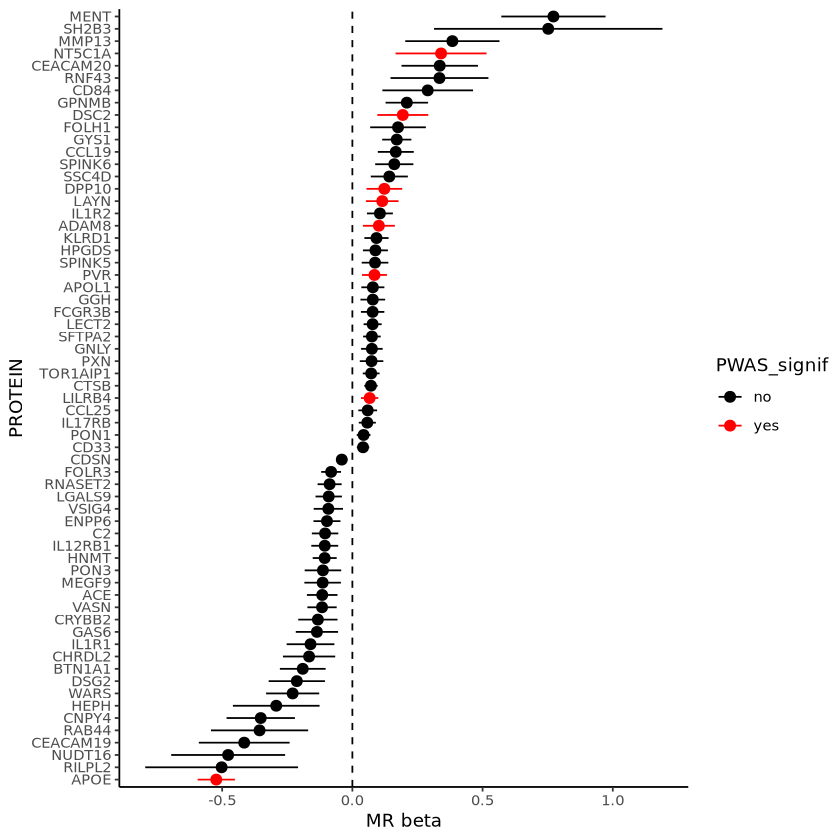

In [192]:
## plot significant proteins
cistrans_signif2 <- 
cistrans_signif %>% 
    mutate(PWAS_signif = ifelse(PROTEIN %in% cistrans_overlap$PROTEIN[cistrans_overlap$same_sign=='yes'], "yes", "no"))

ggplot(cistrans_signif2, aes(x=b, y=PROTEIN, colour=PWAS_signif)) + 
    geom_pointrange(aes(xmin=b-1.96*se, xmax=b+1.96*se)) + 
    geom_vline(xintercept = 0, lty="dashed") + 
    scale_color_manual(values=c("black", "red")) + 
    xlab("MR beta") +
    theme_classic()
ggsave('pQTL_MR_analysis/results/plots/MR_cistrans_r0.2_ukb_results.png', dpi = 500)

##### cis pQLTs

In [193]:
## load data
cis <- fread('pQTL_MR_analysis/results/with_clumped/thres0.2/ukb_nopleio/mr_pQTLs_delirium_1by1_thres0.2_cis_main.csv')
cis_signif <- 
cis %>% 
    filter(fdr < 0.05) %>%
    #filter(pval < 0.05/nrow(.))  %>% 
    arrange(b) %>% 
    mutate(PROTEIN = factor(exposure, levels = exposure)) 
cis_signif %>% nrow
cis_signif %>% tail(3)

[1] 53

outcome,exposure,method,nsnp,b,se,pval,fdr,PROTEIN
<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
delirium_ukb,NT5C1A,IVW,3,0.4843686,0.1429601,7.036889e-04,3.135926e-02,NT5C1A
delirium_ukb,SH2B3,IVW,4,0.7520934,0.2237291,7.748523e-04,3.284618e-02,SH2B3
delirium_ukb,MENT,IVW,9,0.9303266,0.1063181,2.125877e-18,1.847387e-15,MENT


In [194]:
# proteins with MR-pval < 0.05 (fdr) & PWAS pval < 0.05 (fdr)
overlap <-
cis_signif %>% 
    left_join(., a[,c("PROTEIN","BETA","STDERR","PVALUE","fdr.pwas")], by = "PROTEIN") %>%
    filter(fdr.pwas < 0.05) %>%
    mutate(same_sign = ifelse(BETA*b > 0, 'yes', 'no')) 

printcmd <- paste0(nrow(overlap), ' proteins singificant in both MR and PWAS (FDR q < 0.05 ), ', nrow(overlap[overlap$same_sign == 'yes',]), ' with same direction of effect')
print(printcmd)
overlap[overlap$same_sign == 'yes',]

[1] "13 proteins singificant in both MR and PWAS (FDR q < 0.05 ), 8 with same direction of effect"


outcome,exposure,method,nsnp,b,se,pval,fdr,PROTEIN,BETA,STDERR,PVALUE,fdr.pwas,same_sign
<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
delirium_ukb,APOE,IVW,36,-0.52557330,0.03683868,3.519371e-46,6.116667e-43,APOE,-0.1502851,0.04466934,7.671292e-04,0.0092428346,yes
delirium_ukb,PILRA,IVW,92,0.04356412,0.01353410,1.287097e-03,4.525121e-02,PILRA,0.1853546,0.04463898,3.291455e-05,0.0007527836,yes
delirium_ukb,PVR,IVW,45,0.08540393,0.02461121,5.202209e-04,2.475338e-02,PVR,0.1739415,0.04472201,1.004948e-04,0.0018222301,yes
delirium_ukb,ADAM8,IVW,22,0.10310541,0.03180558,1.188024e-03,4.301636e-02,ADAM8,0.1752071,0.04474167,9.004042e-05,0.0016956643,yes
delirium_ukb,LAYN,IVW,31,0.11837855,0.03231289,2.487843e-04,1.490990e-02,LAYN,0.1360131,0.04452539,2.252619e-03,0.0215205331,yes
delirium_ukb,DPP10,IVW,35,0.13604936,0.03534930,1.187392e-04,7.894290e-03,DPP10,0.1330704,0.04397378,2.477046e-03,0.0231006299,yes
delirium_ukb,DSC2,IVW,18,0.19762806,0.05129216,1.166852e-04,7.894290e-03,DSC2,0.2154519,0.04557869,2.278272e-06,0.0001007618,yes
delirium_ukb,NT5C1A,IVW,3,0.48436858,0.14296012,7.036889e-04,3.135926e-02,NT5C1A,0.2113186,0.05023325,2.590730e-05,0.0006354909,yes


Saving 7 x 7 in image


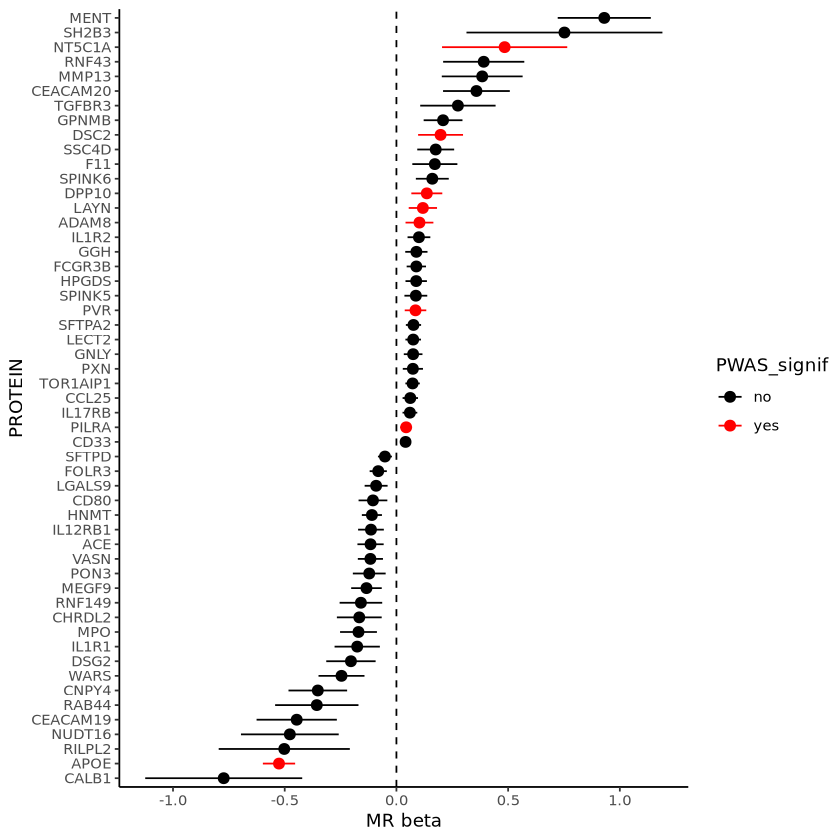

In [195]:
## plot significant proteins
cis_signif2 <- 
cis_signif %>% 
    mutate(PWAS_signif = ifelse(PROTEIN %in% overlap$PROTEIN[overlap$same_sign=='yes'], "yes", "no"))

ggplot(cis_signif2, aes(x=b, y=PROTEIN, colour=PWAS_signif)) + 
    geom_pointrange(aes(xmin=b-1.96*se, xmax=b+1.96*se)) + 
    geom_vline(xintercept = 0, lty="dashed") + 
    scale_color_manual(values=c("black", "red")) + 
    xlab("MR beta") +
    theme_classic()
ggsave('pQTL_MR_analysis/results/plots/MR_cis_r0.2_ukb_results.png', dpi = 500)

In [197]:
cis_signif2 %>% group_by(PWAS_signif) %>% summarise(n=n())

PWAS_signif,n
<chr>,<int>
no,45
yes,8


### Individual protein plots:

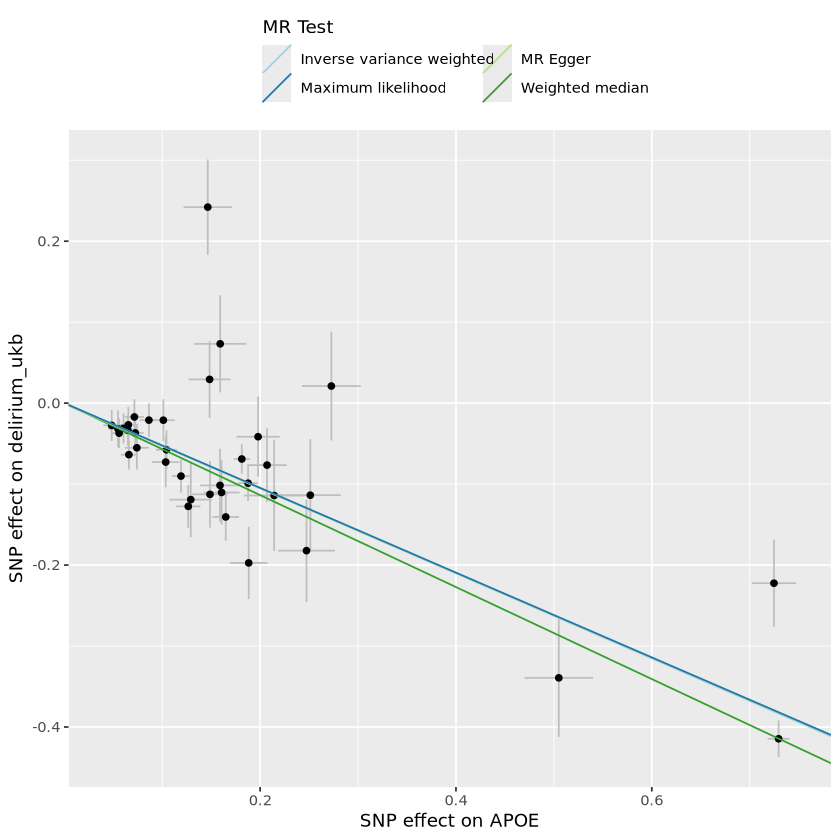

In [198]:
mr_scatter_plot(mr_all_cis[mr_all_cis$exposure=="APOE",], harmon_cis_nopleio[harmon_cis_nopleio$exposure=="APOE",])[[1]] 

Warning message:
“Removed 1 row containing missing values or values outside the scale range (`geom_errorbarh()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range (`geom_point()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range (`geom_errorbarh()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range (`geom_point()`).”


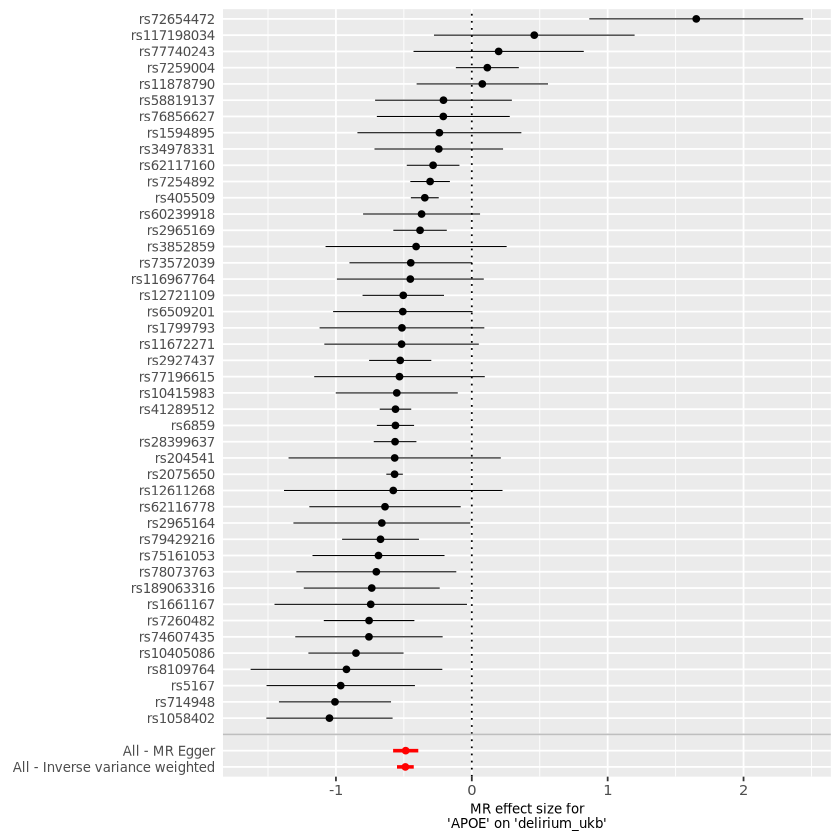

$DwGW3H.GkofmA

attr(,"split_type")
[1] "data.frame"
attr(,"split_labels")
  id.exposure id.outcome
1      DwGW3H     GkofmA

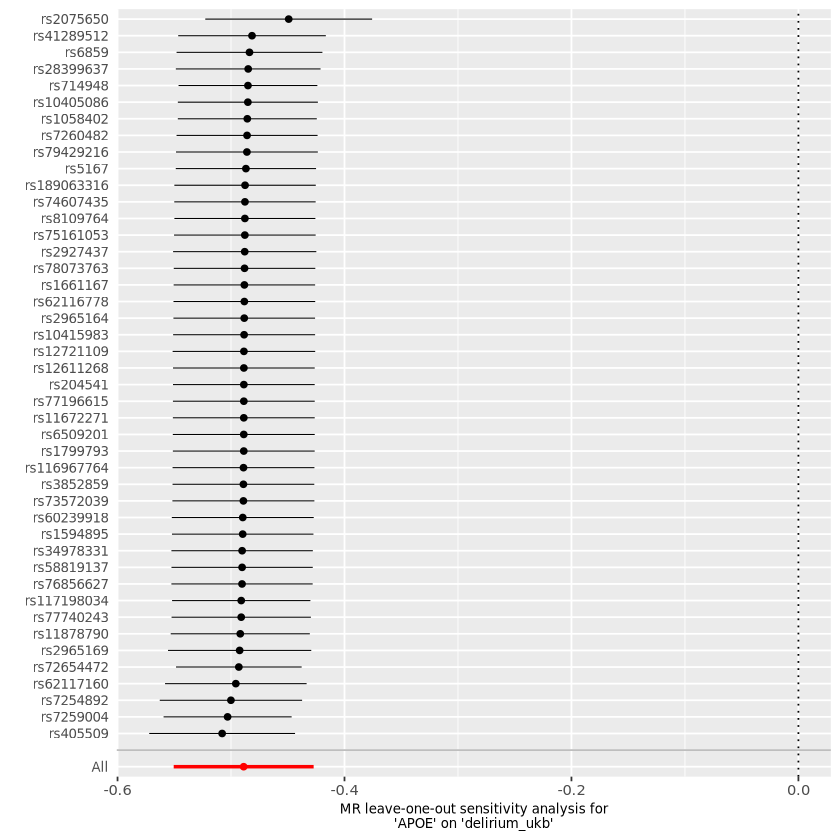

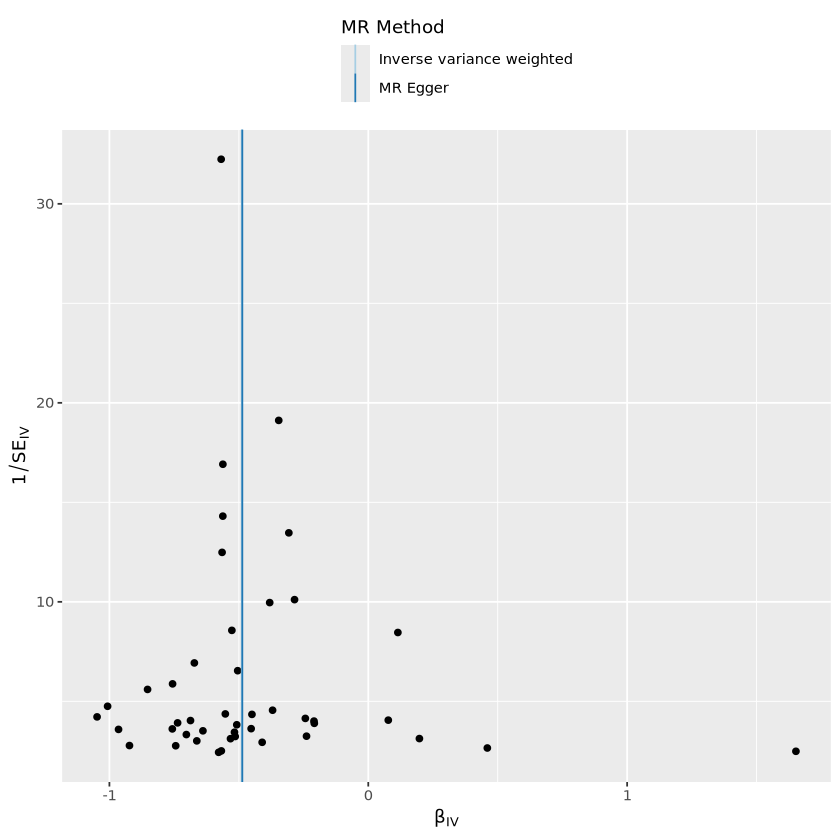

In [199]:
# forrest plot
library(patchwork)
mr_apoe <- mr_singlesnp(harmon_cis[harmon_cis$exposure=="APOE",])
p1 <- mr_forest_plot(mr_apoe)[[1]]
# leave one out (MR excluding each pQLT one by one)
mr_loo_apoe <- mr_leaveoneout(harmon_cis[harmon_cis$exposure=="APOE",])
p2 <- mr_leaveoneout_plot(mr_loo_apoe)[[1]]
# funnel plot
p3 <- mr_funnel_plot(mr_apoe)
p1
p2
p3

### Compare across r^2 thresholds:

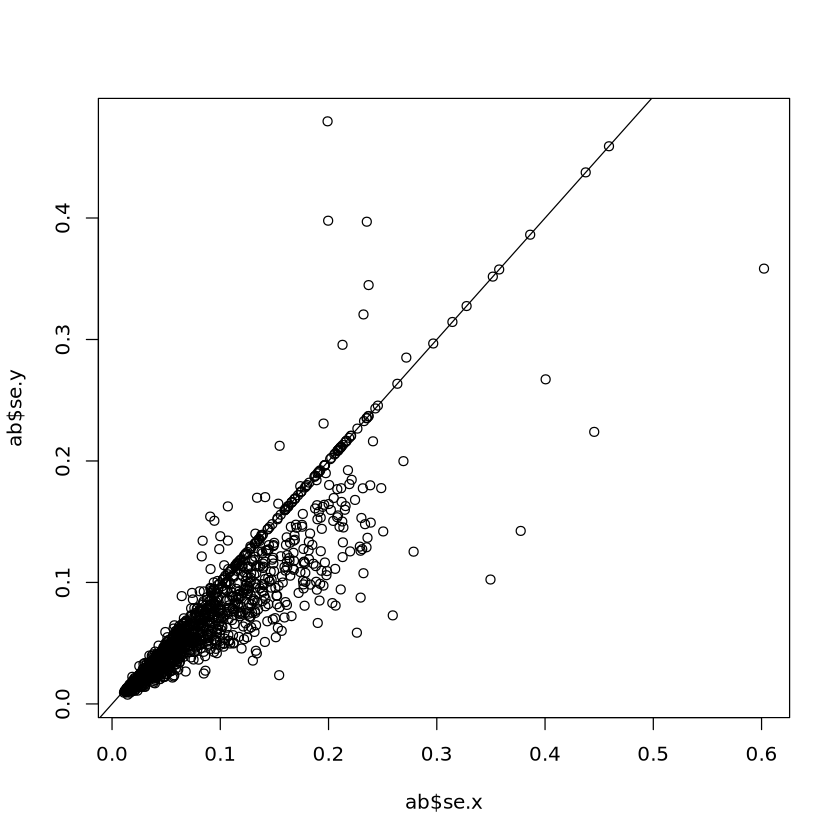

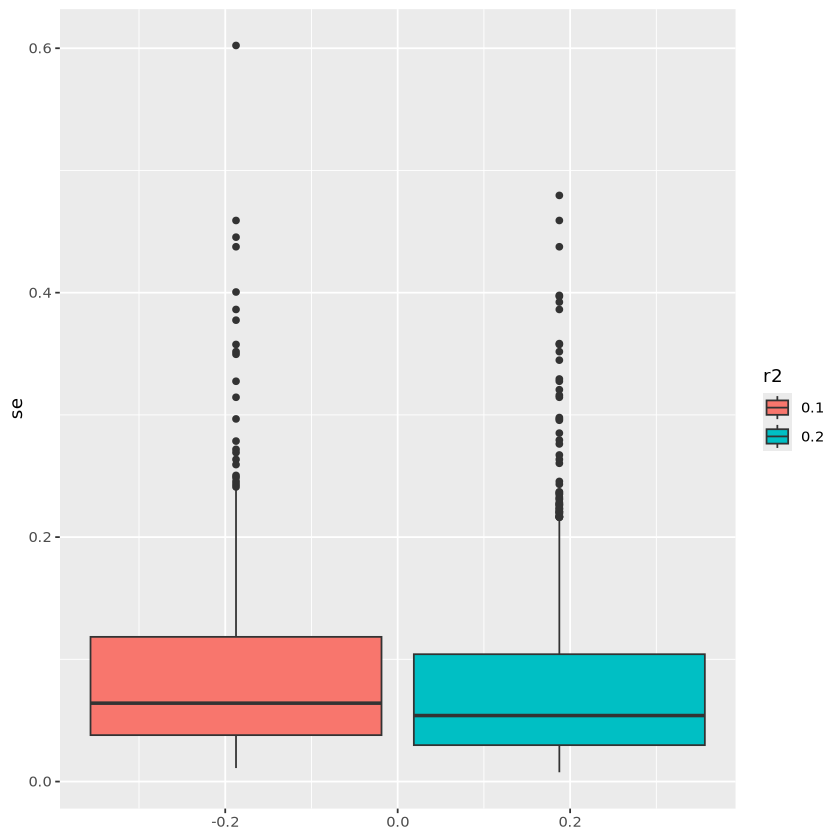

In [57]:
## compare across r2 thresholds (not abrupt se difference)
a <- fread("pQTL_MR_analysis/results/mr_pQTLs_delirium_1by1_thres0.1_cis_main.txt") %>% filter(method=="IVW") %>% mutate(r2 = "0.1")
b <- fread("pQTL_MR_analysis/results/mr_pQTLs_delirium_1by1_thres0.2_cis_main.txt") %>% filter(method=="IVW") %>% mutate(r2 = "0.2")
ab <- inner_join(a, b, by="exposure") 
plot(ab$se.x, ab$se.y)
abline(a=0,b=1)
ab <- bind_rows(a,b)
ggplot(ab, aes(y=se, fill=r2)) +
geom_boxplot() 

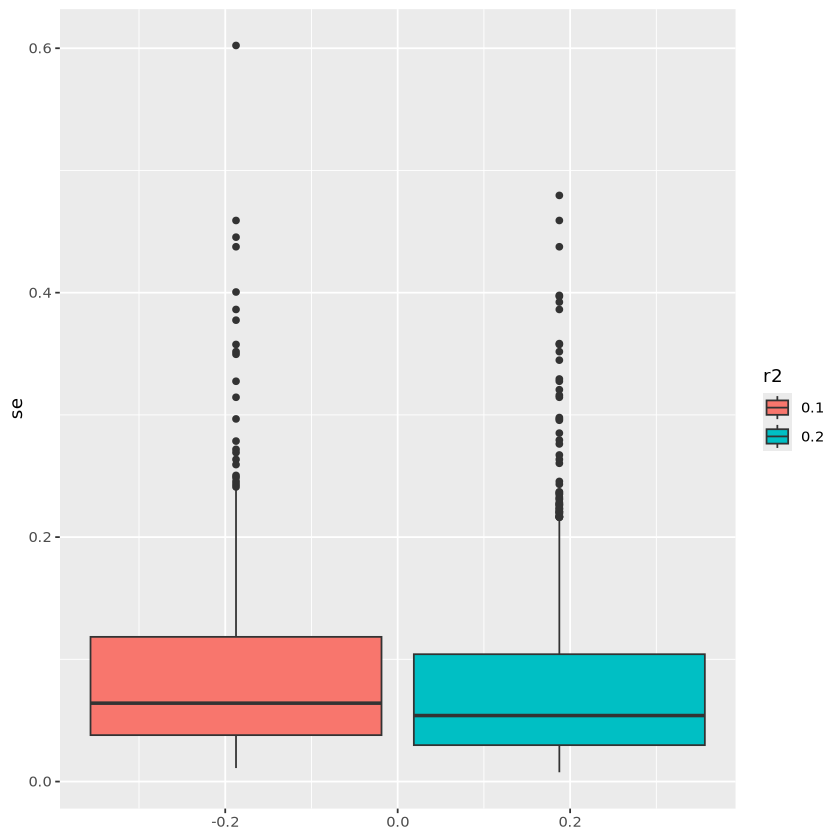